In [1]:
# ============================================================================
# CELL 1: SETUP - Import libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix, save_npz, load_npz
import pickle
import os
import re
import warnings
import glob
import gc

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check for GPU availability
USE_GPU = False
USE_RAPIDS = False

try:
    import cudf
    import cuml
    from cuml.feature_extraction.text import TfidfVectorizer as cuTfidfVectorizer
    from cuml.metrics.pairwise import cosine_similarity as cu_cosine_similarity
    USE_RAPIDS = True
    USE_GPU = True
    print("✅ RAPIDS/cuML detected - GPU acceleration available!")
except ImportError:
    print("⚠️  RAPIDS not available - using CPU (scikit-learn)")
    print("   To use GPU: Install RAPIDS in Kaggle notebook settings or use GPU runtime")

# Check CUDA availability (for PyTorch/TensorFlow if needed)
try:
    import torch
    if torch.cuda.is_available():
        USE_GPU = True
        print(f"✅ PyTorch CUDA available - GPU: {torch.cuda.get_device_name(0)}")
        print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
except:
    pass

# Memory optimization settings
# ⚠️  Nếu CPU bị quá tải, hãy set các giá trị sau:
CHUNK_SIZE = 100000  # Process data in chunks to reduce memory
MAX_GAMES = None  # Set to limit number of games (e.g., 50000) if memory issues
MAX_RATINGS = None  # Set to limit number of ratings (e.g., 1000000) if memory issues

# Ví dụ để giảm tải CPU:
# MAX_GAMES = 50000  # Chỉ dùng 50k games đầu tiên
# MAX_RATINGS = 1000000  # Chỉ dùng 1M ratings đầu tiên

print("✅ Libraries imported successfully")
print(f"📊 Configuration: GPU={USE_GPU}, RAPIDS={USE_RAPIDS}")

⚠️  RAPIDS not available - using CPU (scikit-learn)
   To use GPU: Install RAPIDS in Kaggle notebook settings or use GPU runtime
✅ PyTorch CUDA available - GPU: Tesla T4
   GPU Memory: 15.83 GB
✅ Libraries imported successfully
📊 Configuration: GPU=True, RAPIDS=False


In [2]:
# ============================================================================
# CELL 2: DATA COLLECTION - Load dataset
# ============================================================================
print("\n" + "="*60)
print("PART 1: DATA COLLECTION")
print("="*60)

# Find dataset path
dataset_base_paths = [
    '/kaggle/input/game-recommendations-on-steam',
    '/kaggle/input/game-recommendations-on-steam-dataset',
    '/kaggle/input/steam-game-recommendations'
]

base_path = None
for path in dataset_base_paths:
    if os.path.exists(path):
        base_path = path
        print(f"✅ Found dataset at: {path}")
        break

if base_path is None:
    # Try to find any directory with games.csv
    possible_games = glob.glob('/kaggle/input/**/games.csv', recursive=True)
    if possible_games:
        base_path = os.path.dirname(possible_games[0])
        print(f"✅ Found dataset at: {base_path}")
    else:
        raise FileNotFoundError("Please add 'Game Recommendations on Steam' dataset to your Kaggle notebook")

# Load games.csv
games_path = os.path.join(base_path, 'games.csv')
if not os.path.exists(games_path):
    raise FileNotFoundError(f"games.csv not found at {games_path}")

# Load games with memory optimization
print("Loading games.csv...")
if MAX_GAMES:
    games = pd.read_csv(games_path, low_memory=False, nrows=MAX_GAMES)
    print(f"⚠️  Limited to {MAX_GAMES} games for memory optimization")
else:
    games = pd.read_csv(games_path, low_memory=False)
print(f"✅ Loaded games.csv: {len(games)} games")
print(f"Games columns: {games.columns.tolist()}")
print(f"Memory usage: {games.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Load recommendations.csv
recommendations_path = os.path.join(base_path, 'recommendations.csv')
if not os.path.exists(recommendations_path):
    raise FileNotFoundError(f"recommendations.csv not found at {recommendations_path}")

# Load recommendations with memory optimization
print("Loading recommendations.csv...")
if MAX_RATINGS:
    recommendations = pd.read_csv(recommendations_path, low_memory=False, nrows=MAX_RATINGS)
    print(f"⚠️  Limited to {MAX_RATINGS} ratings for memory optimization")
else:
    # Load in chunks if file is very large
    try:
        file_size = os.path.getsize(recommendations_path) / (1024**3)  # GB
        if file_size > 1.0:  # If file > 1GB, load in chunks
            print(f"⚠️  Large file detected ({file_size:.2f} GB), loading in chunks...")
            chunk_list = []
            for chunk in pd.read_csv(recommendations_path, low_memory=False, chunksize=CHUNK_SIZE):
                chunk_list.append(chunk)
                if len(chunk_list) * CHUNK_SIZE >= MAX_RATINGS if MAX_RATINGS else False:
                    break
            recommendations = pd.concat(chunk_list, ignore_index=True)
            del chunk_list
            gc.collect()
        else:
            recommendations = pd.read_csv(recommendations_path, low_memory=False)
    except:
        recommendations = pd.read_csv(recommendations_path, low_memory=False)

print(f"✅ Loaded recommendations.csv: {len(recommendations)} recommendations")
print(f"Recommendations columns: {recommendations.columns.tolist()}")
print(f"Memory usage: {recommendations.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nSample recommendations:")
print(recommendations.head())

# Load users.csv (optional)
users_path = os.path.join(base_path, 'users.csv')
users = None
if os.path.exists(users_path):
    users = pd.read_csv(users_path, low_memory=False)
    print(f"✅ Loaded users.csv: {len(users)} users")
    print(f"Users columns: {users.columns.tolist()}")
else:
    print("⚠️  users.csv not found (optional)")


PART 1: DATA COLLECTION
✅ Found dataset at: /kaggle/input/game-recommendations-on-steam
Loading games.csv...
✅ Loaded games.csv: 50872 games
Games columns: ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']
Memory usage: 11.86 MB
Loading recommendations.csv...
⚠️  Large file detected (1.88 GB), loading in chunks...
✅ Loaded recommendations.csv: 41154794 recommendations
Recommendations columns: ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours', 'user_id', 'review_id']
Memory usage: 4238.81 MB

Sample recommendations:
    app_id  helpful  funny        date  is_recommended  hours  user_id  \
0   975370        0      0  2022-12-12            True   36.3    51580   
1   304390        4      0  2017-02-17           False   11.5     2586   
2  1085660        2      0  2019-11-17            True  336.5   253880   
3   703080        0      0  2022-09-23            True 

In [3]:
# ============================================================================
# CELL 3: DATA CLEANING - Standardize columns
# ============================================================================
print("\n" + "="*60)
print("PART 2: DATA CLEANING & PREPROCESSING")
print("="*60)

# Standardize column names for games
games_df = games.copy()

# Standardize game_id
if 'app_id' in games_df.columns:
    games_df.rename(columns={'app_id': 'game_id'}, inplace=True)
elif 'appid' in games_df.columns:
    games_df.rename(columns={'appid': 'game_id'}, inplace=True)
elif 'id' in games_df.columns:
    games_df.rename(columns={'id': 'game_id'}, inplace=True)
else:
    games_df['game_id'] = games_df.index + 1

# Standardize title
if 'title' not in games_df.columns:
    if 'name' in games_df.columns:
        games_df.rename(columns={'name': 'title'}, inplace=True)
    elif 'game' in games_df.columns:
        games_df.rename(columns={'game': 'title'}, inplace=True)
    else:
        games_df['title'] = 'Unknown Game'

print(f"✅ Standardized games columns")
print(f"Games shape: {games_df.shape}")


PART 2: DATA CLEANING & PREPROCESSING
✅ Standardized games columns
Games shape: (50872, 13)


In [4]:
# ============================================================================
# CELL 4: OPTIMIZED DATA PROCESSING WITH IMPROVED RATING CALCULATION
# ============================================================================
import numpy as np
import pandas as pd
import gc
import os

print("="*60)
print("PART 2: OPTIMIZED DATA PROCESSING")
print("="*60)

# 1. LOAD FULL DATA
csv_path = '/kaggle/input/game-recommendations-on-steam/recommendations.csv'
print("Loading dataset...")
ratings_df = pd.read_csv(csv_path)
print(f"✅ Loaded {len(ratings_df):,} records")

# 2. RENAME COLUMNS (Fuzzy Match)
print("Renaming columns...")
ratings_df.columns = ratings_df.columns.astype(str).str.strip().str.lower()
rename_map = {}
for col in ratings_df.columns:
    if 'recommend' in col or 'vote' in col: 
        rename_map[col] = 'is_recommended'
    elif 'hour' in col or 'playtime' in col: 
        rename_map[col] = 'hours'
    elif 'app' in col and 'id' in col: 
        rename_map[col] = 'game_id'
    elif 'appid' == col: 
        rename_map[col] = 'game_id'
    elif 'user' in col or 'steam' in col: 
        rename_map[col] = 'user_id'
    elif 'date' in col: 
        rename_map[col] = 'date'

ratings_df.rename(columns=rename_map, inplace=True)

# Drop unused columns early to save RAM
keep_cols = [c for c in ['user_id', 'game_id', 'is_recommended', 'hours', 'date'] 
             if c in ratings_df.columns]
ratings_df = ratings_df[keep_cols]
gc.collect()

print(f"✅ Columns prepared: {ratings_df.columns.tolist()}")

# ============================================================================
# 3. IMPROVED RATING CALCULATION SYSTEM
# ============================================================================
print("\n" + "="*60)
print("CALCULATING RATINGS WITH IMPROVED ALGORITHM")
print("="*60)

if 'hours' in ratings_df.columns and 'is_recommended' in ratings_df.columns:
    # Clean hours data
    ratings_df['hours'] = pd.to_numeric(ratings_df['hours'], errors='coerce')
    ratings_df['hours'] = ratings_df['hours'].fillna(0).clip(lower=0)
    
    # Convert recommendation to boolean
    rec_bool = ratings_df['is_recommended'].astype(str).str.lower().isin(['true', '1', 'yes'])
    
    hours = ratings_df['hours'].values
    
    # Define hour thresholds
    def calculate_rating_vectorized(hours, is_recommended):
        rating = np.zeros(len(hours))
        
        if is_recommended:
            # RECOMMENDED ratings (3.5 to 5.0)
            rating[hours < 1] = 3.5
            rating[(hours >= 1) & (hours < 10)] = 4.0
            rating[(hours >= 10) & (hours < 30)] = 4.5
            rating[(hours >= 30) & (hours < 100)] = 4.7
            rating[hours >= 100] = 5.0
        else:
            # NOT RECOMMENDED ratings (1.5 to 3.5)
            rating[hours < 1] = 1.5
            rating[(hours >= 1) & (hours < 10)] = 2.0
            rating[(hours >= 10) & (hours < 30)] = 2.5
            rating[(hours >= 30) & (hours < 100)] = 3.0
            rating[hours >= 100] = 3.5
        
        return rating
    
    # Apply rating calculation
    ratings_df['rating'] = np.where(
        rec_bool,
        calculate_rating_vectorized(hours, True),
        calculate_rating_vectorized(hours, False)
    )
    
    # Round to 1 decimal place
    ratings_df['rating'] = ratings_df['rating'].round(1)
    
    # Display rating distribution
    print("\n📊 Rating Distribution Analysis:")
    print("-" * 60)
    rating_dist = ratings_df['rating'].value_counts().sort_index()
    for rating, count in rating_dist.items():
        percentage = (count / len(ratings_df)) * 100
        bar = '█' * int(percentage / 2)
        print(f"{rating:.1f} | {bar} {percentage:5.2f}% ({count:,})")
    
    print("\n📊 Recommendation vs Hours Statistics:")
    print("-" * 60)
    rec_stats = ratings_df.groupby('is_recommended').agg({
        'hours': ['count', 'mean', 'median', 'min', 'max'],
        'rating': ['mean', 'std']
    }).round(2)
    print(rec_stats)
    
else:
    # Fallback if columns missing
    print("⚠️  Hours or recommendation data not available, using simple binary rating")
    rec_bool = ratings_df['is_recommended'].astype(str).str.lower().isin(['true', '1', 'yes'])
    ratings_df['rating'] = np.where(rec_bool, 4.5, 2.0)

# ============================================================================
# 4. FINALIZE & CLEANUP
# ============================================================================
print("\n" + "="*60)
print("FINALIZING DATA")
print("="*60)

# Handle timestamps
if 'date' in ratings_df.columns:
    print("Processing dates...")
    ratings_df['timestamp'] = pd.to_datetime(ratings_df['date'], errors='coerce')
    ratings_df['timestamp'] = ratings_df['timestamp'].fillna(pd.Timestamp('2020-01-01'))
    ratings_df['timestamp'] = ratings_df['timestamp'].astype(np.int64) // 10**9
else:
    ratings_df['timestamp'] = 1600000000

# Select final columns
final_cols = ['user_id', 'game_id', 'rating', 'timestamp']
ratings_df = ratings_df[[c for c in final_cols if c in ratings_df.columns]]

# Remove invalid data
print("Cleaning data...")
initial_count = len(ratings_df)
ratings_df = ratings_df.dropna()
ratings_df = ratings_df[(ratings_df['rating'] >= 1) & (ratings_df['rating'] <= 5)]
ratings_df = ratings_df.drop_duplicates(subset=['user_id', 'game_id'], keep='last')

print(f"✅ Removed {initial_count - len(ratings_df):,} invalid/duplicate records")

# Memory optimization
ratings_df['user_id'] = ratings_df['user_id'].astype('int32')
ratings_df['game_id'] = ratings_df['game_id'].astype('int32')
ratings_df['rating'] = ratings_df['rating'].astype('float32')
ratings_df['timestamp'] = ratings_df['timestamp'].astype('int64')

gc.collect()

# Handle games metadata (dummy if missing)
if 'games_df' not in globals():
    print("Creating game metadata...")
    unique_games = ratings_df['game_id'].unique()
    games_df = pd.DataFrame({
        'game_id': unique_games,
        'title_clean': [f'Game_{gid}' for gid in unique_games],
        'genres': 'Unknown',
        'year': 2020,
        'price': 0.0
    })
    games_clean = games_df

# Alias for compatibility
ratings_clean = ratings_df

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("✅ DATA PROCESSING COMPLETED!")
print("="*60)
print(f"📊 Total ratings: {len(ratings_df):,}")
print(f"👥 Unique users: {ratings_df['user_id'].nunique():,}")
print(f"🎮 Unique games: {ratings_df['game_id'].nunique():,}")
print(f"⭐ Average rating: {ratings_df['rating'].mean():.2f}")
print(f"📈 Rating std dev: {ratings_df['rating'].std():.2f}")
print(f"💾 Memory usage: {ratings_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("="*60)

# Display sample data
print("\n📋 Sample data (first 5 rows):")
print(ratings_df.head())

# Rating quality check
print("\n🔍 Rating Quality Check:")
print(f"Min rating: {ratings_df['rating'].min()}")
print(f"Max rating: {ratings_df['rating'].max()}")
print(f"Median rating: {ratings_df['rating'].median()}")
print(f"25th percentile: {ratings_df['rating'].quantile(0.25)}")
print(f"75th percentile: {ratings_df['rating'].quantile(0.75)}")
print("="*60)

PART 2: OPTIMIZED DATA PROCESSING
Loading dataset...
✅ Loaded 41,154,794 records
Renaming columns...
✅ Columns prepared: ['user_id', 'game_id', 'is_recommended', 'hours', 'date']

CALCULATING RATINGS WITH IMPROVED ALGORITHM

📊 Rating Distribution Analysis:
------------------------------------------------------------
1.5 | █  2.24% (922,563)
2.0 | ██  4.60% (1,893,508)
2.5 | █  2.44% (1,004,172)
3.0 | █  2.23% (917,763)
3.5 | ██  5.71% (2,351,551)
4.0 | █████████ 19.36% (7,969,144)
4.5 | ██████████ 20.25% (8,335,001)
4.7 | ██████████ 20.98% (8,633,563)
5.0 | ███████████ 22.18% (9,127,529)

📊 Recommendation vs Hours Statistics:
------------------------------------------------------------
                   hours                             rating      
                   count    mean median  min     max   mean   std
is_recommended                                                   
False            5850396   80.89   11.1  0.0  1000.0   2.45  0.68
True            35304398  103.87   30.3  

In [5]:
ENABLE_USER_FILTER = True  # Đặt False để giữ tất cả users
TOP_N_USERS = 1_000_000

if ENABLE_USER_FILTER:
    print("\n" + "="*60)
    print("FILTERING TOP USERS (REDUCE MODEL SIZE)")
    print("="*60)
    
    # Đếm số ratings của mỗi user
    print("📊 Counting ratings per user...")
    user_rating_counts = ratings_df['user_id'].value_counts()
    print(f"   Total users: {len(user_rating_counts):,}")
    print(f"   Users with 1 rating: {(user_rating_counts == 1).sum():,}")
    print(f"   Users with 10+ ratings: {(user_rating_counts >= 10).sum():,}")
    print(f"   Users with 100+ ratings: {(user_rating_counts >= 100).sum():,}")
    
    # Lấy top N users
    top_users = user_rating_counts.head(TOP_N_USERS).index.tolist()
    print(f"\n✅ Selected top {len(top_users):,} users")
    print(f"   Min ratings per user: {user_rating_counts.iloc[TOP_N_USERS-1]}")
    print(f"   Max ratings per user: {user_rating_counts.iloc[0]}")
    
    # Lọc ratings
    ratings_before = len(ratings_df)
    ratings_df = ratings_df[ratings_df['user_id'].isin(top_users)].copy()
    ratings_after = len(ratings_df)
    
    print(f"\n📉 Ratings reduction:")
    print(f"   Before: {ratings_before:,}")
    print(f"   After: {ratings_after:,}")
    print(f"   Reduction: {(1 - ratings_after/ratings_before)*100:.1f}%")
    
    # Update games_df - chỉ giữ games có ratings từ top users
    games_with_ratings = ratings_df['game_id'].unique()
    games_df = games_df[games_df['game_id'].isin(games_with_ratings)].copy()
    print(f"\n📉 Games reduction:")
    print(f"   Games with ratings from top users: {len(games_with_ratings):,}")
    
    # Clean up
    del user_rating_counts, top_users, games_with_ratings
    gc.collect()
    
    print("\n✅ Filtered to top users successfully!")
    print("="*60)
else:
    print("\n⚠️  User filter disabled - using all users")


FILTERING TOP USERS (REDUCE MODEL SIZE)
📊 Counting ratings per user...
   Total users: 13,781,059
   Users with 1 rating: 7,573,027
   Users with 10+ ratings: 680,809
   Users with 100+ ratings: 8,364

✅ Selected top 1,000,000 users
   Min ratings per user: 7
   Max ratings per user: 6045

📉 Ratings reduction:
   Before: 41,154,773
   After: 17,238,599
   Reduction: 58.1%

📉 Games reduction:
   Games with ratings from top users: 37,383

✅ Filtered to top users successfully!


In [6]:
# ============================================================================
# CELL 5: LOAD METADATA JSON & PROCESS GAMES DATA
# ============================================================================
import json
import re

print("\n" + "="*60)
print("CELL 5: LOADING METADATA & PROCESSING GAMES")
print("="*60)

# ============================================================================
# STEP 1: LOAD GAMES METADATA JSON (FOR GENRES/TAGS)
# ============================================================================
metadata_path = '/kaggle/input/game-recommendations-on-steam/games_metadata.json'

print("\n1. Loading games_metadata.json...")
try:
    # Read the file line by line since it's not a valid single JSON
    metadata = {}
    
    with open(metadata_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            
            try:
                # Parse each line as a separate JSON object
                game_data = json.loads(line)
                
                # Use app_id as the key
                if 'app_id' in game_data:
                    game_id = str(game_data['app_id'])
                    metadata[game_id] = game_data
                    
            except json.JSONDecodeError as e:
                if line_num <= 5:  # Only print first few errors
                    print(f"⚠️  Skipping invalid JSON on line {line_num}: {str(e)[:50]}")
                continue
    
    print(f"✅ Loaded metadata for {len(metadata):,} games")
    
    # Convert to DataFrame
    metadata_records = []
    
    for game_id, game_data in metadata.items():
        try:
            # Extract tags (genres)
            tags = game_data.get('tags', [])
            if isinstance(tags, list) and len(tags) > 0:
                # Take top 7 tags as main genres
                main_genres = ', '.join(tags[:7])
                all_tags = ', '.join(tags)
            else:
                main_genres = 'Unknown'
                all_tags = ''
            
            # Extract other fields
            record = {
                'game_id': int(game_id),
                'genres': main_genres,
                'all_tags': all_tags,
                'description': game_data.get('description', '')[:200],  # First 200 chars
            }
            
            metadata_records.append(record)
            
        except Exception as e:
            continue
    
    # Create metadata DataFrame
    metadata_df = pd.DataFrame(metadata_records)
    
    print(f"✅ Processed {len(metadata_df):,} game metadata records")
    print(f"✅ Games with genres: {(metadata_df['genres'] != 'Unknown').sum():,}")
    
    # Display sample
    print("\n📋 Sample metadata:")
    print(metadata_df[['game_id', 'genres']].head(3))
    
except FileNotFoundError:
    print("⚠️  Warning: games_metadata.json not found, will use empty genres")
    metadata_df = pd.DataFrame(columns=['game_id', 'genres', 'all_tags', 'description'])
except Exception as e:
    print(f"⚠️  Error loading metadata: {e}")
    metadata_df = pd.DataFrame(columns=['game_id', 'genres', 'all_tags', 'description'])

# ============================================================================
# STEP 2: CLEAN AND PROCESS GAMES DATA
# ============================================================================
print("\n2. Processing games data...")

# Clean title
games_df['title'] = games_df['title'].fillna('Unknown Game').astype(str).str.strip()
games_df['title_clean'] = games_df['title']

# Extract year from release_date
if 'date_release' in games_df.columns:
    try:
        games_df['release_date_parsed'] = pd.to_datetime(games_df['date_release'], errors='coerce')
        games_df['year'] = games_df['release_date_parsed'].dt.year
    except:
        games_df['year'] = games_df['date_release'].astype(str).str.extract(r'(\d{4})')[0]
        games_df['year'] = pd.to_numeric(games_df['year'], errors='coerce')
elif 'release_date' in games_df.columns:
    try:
        games_df['release_date_parsed'] = pd.to_datetime(games_df['release_date'], errors='coerce')
        games_df['year'] = games_df['release_date_parsed'].dt.year
    except:
        games_df['year'] = games_df['release_date'].astype(str).str.extract(r'(\d{4})')[0]
        games_df['year'] = pd.to_numeric(games_df['year'], errors='coerce')
elif 'year' in games_df.columns:
    games_df['year'] = pd.to_numeric(games_df['year'], errors='coerce')
else:
    games_df['year'] = None

# Handle price - check multiple possible column names
# Priority: price_final (after discount) > price_original > price > initial_price
if 'price_final' in games_df.columns:
    games_df['price'] = pd.to_numeric(games_df['price_final'], errors='coerce')
    games_df['price'] = games_df['price'].fillna(0)
    print(f"✅ Using price_final column for prices")
elif 'price_original' in games_df.columns:
    games_df['price'] = pd.to_numeric(games_df['price_original'], errors='coerce')
    games_df['price'] = games_df['price'].fillna(0)
    print(f"✅ Using price_original column for prices")
elif 'price' in games_df.columns:
    games_df['price'] = pd.to_numeric(games_df['price'], errors='coerce')
    games_df['price'] = games_df['price'].fillna(0)
    print(f"✅ Using price column for prices")
elif 'initial_price' in games_df.columns:
    games_df['price'] = pd.to_numeric(games_df['initial_price'], errors='coerce')
    games_df['price'] = games_df['price'].fillna(0)
    print(f"✅ Using initial_price column for prices")
else:
    games_df['price'] = 0
    print(f"⚠️  No price column found, setting all prices to 0")

# Convert price to USD (if needed) - Steam prices are usually in USD already
# But if prices seem too high (e.g., > 1000), might be in cents
if games_df['price'].max() > 1000:
    print(f"⚠️  Prices seem high (max: {games_df['price'].max():.2f}), checking if in cents...")
    # Check if dividing by 100 makes more sense
    if (games_df['price'] / 100).max() < 200:
        games_df['price'] = games_df['price'] / 100
        print(f"✅ Converted prices from cents to dollars")

# Display price statistics
non_zero_prices = games_df[games_df['price'] > 0]['price']
if len(non_zero_prices) > 0:
    print(f"📊 Price statistics:")
    print(f"   - Games with price > 0: {len(non_zero_prices):,} ({len(non_zero_prices)/len(games_df)*100:.1f}%)")
    print(f"   - Min price: ${non_zero_prices.min():.2f}")
    print(f"   - Max price: ${non_zero_prices.max():.2f}")
    print(f"   - Mean price: ${non_zero_prices.mean():.2f}")
    print(f"   - Median price: ${non_zero_prices.median():.2f}")
else:
    print(f"⚠️  Warning: All prices are 0!")

# Fill missing year
if games_df['year'].notna().any():
    games_df['year'] = games_df['year'].fillna(games_df['year'].median())
else:
    games_df['year'] = 2020

current_year = pd.Timestamp.now().year
games_df['year'] = games_df['year'].clip(lower=1980, upper=current_year)

print(f"✅ Processed basic games data")

# ============================================================================
# CELL 6: MERGE METADATA & PROCESS GENRES
# ============================================================================
print("\n" + "="*60)
print("CELL 6: MERGING METADATA & PROCESSING GENRES")
print("="*60)

# ============================================================================
# STEP 1: MERGE METADATA WITH GAMES_DF
# ============================================================================
print("\n1. Merging metadata...")

if len(metadata_df) > 0:
    print(f"Before merge: {len(games_df):,} games")
    print(f"Metadata available: {len(metadata_df):,} games")
    
    # Merge metadata (left join to keep all games)
    games_df = games_df.merge(
        metadata_df[['game_id', 'genres', 'all_tags', 'description']], 
        on='game_id', 
        how='left',
        suffixes=('_old', '_meta')
    )
    
    # Prefer metadata genres over existing (if any)
    if 'genres_meta' in games_df.columns:
        # Use metadata genres, fallback to old genres if metadata is missing
        if 'genres_old' in games_df.columns:
            games_df['genres'] = games_df['genres_meta'].fillna(games_df['genres_old'])
            games_df.drop(columns=['genres_old', 'genres_meta'], inplace=True)
        else:
            games_df['genres'] = games_df['genres_meta']
            games_df.drop(columns=['genres_meta'], inplace=True)
    
    # Fill remaining missing genres
    games_df['genres'] = games_df['genres'].fillna('Unknown')
    
    print(f"After merge: {len(games_df):,} games")
    print(f"Games with valid genres: {(games_df['genres'] != 'Unknown').sum():,}")
    
    # Genre statistics
    genre_coverage = (games_df['genres'] != 'Unknown').sum() / len(games_df) * 100
    print(f"Genre coverage: {genre_coverage:.1f}%")
    
else:
    print("⚠️  No metadata available, checking existing genre columns...")
    
    # Try to extract genres from existing columns
    genre_text_parts = []
    for col in ['genres', 'tags', 'categories', 'genre', 'tag', 'category']:
        if col in games_df.columns:
            genre_text_parts.append(games_df[col].fillna('').astype(str))
    
    if genre_text_parts:
        # Combine all genre-related text
        if len(genre_text_parts) > 1:
            games_df['genres_combined'] = genre_text_parts[0]
            for part in genre_text_parts[1:]:
                games_df['genres_combined'] = games_df['genres_combined'] + ' ' + part
        else:
            games_df['genres_combined'] = genre_text_parts[0]
        
        # Parse genre string (remove brackets, quotes)
        def parse_genre_string(s):
            if pd.isna(s) or s == '':
                return 'Unknown'
            s = str(s)
            s = re.sub(r'[\[\]"\']', '', s)
            return s if s.strip() else 'Unknown'
        
        games_df['genres'] = games_df['genres_combined'].apply(parse_genre_string)
    else:
        games_df['genres'] = 'Unknown'

# ============================================================================
# STEP 2: CREATE FEATURE TEXT FOR RECOMMENDATIONS
# ============================================================================
print("\n2. Creating feature text...")

# Create feature text for TF-IDF (combine all features)
games_df['feature_text'] = games_df.apply(
    lambda row: ' '.join([
        str(row.get('title_clean', '')),
        str(row.get('genres', '')),
        str(row.get('description', '')) if pd.notna(row.get('description')) else '',
        str(int(row.get('year', 2020))) if pd.notna(row.get('year')) else '',
    ]),
    axis=1
)

print(f"✅ Created feature text for {len(games_df):,} games")

# ============================================================================
# STEP 3: FINALIZE CLEANED DATA
# ============================================================================
print("\n3. Finalizing cleaned data...")

# Filter games with valid information
games_clean = games_df[games_df['title_clean'] != 'Unknown Game'].copy()
games_clean = games_clean.drop_duplicates(subset=['game_id'])

# Filter to only games that have ratings
games_with_ratings = set(ratings_df['game_id'].unique())
games_clean = games_clean[games_clean['game_id'].isin(games_with_ratings)].copy()

# Filter ratings to only games in games_clean
games_in_clean = set(games_clean['game_id'].unique())
ratings_clean = ratings_df[ratings_df['game_id'].isin(games_in_clean)].copy()

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*60)
print("✅ DATA CLEANING COMPLETED!")
print("="*60)
print(f"📊 Final cleaned data:")
print(f"   - Games: {len(games_clean):,}")
print(f"   - Ratings: {len(ratings_clean):,}")
print(f"   - Users: {ratings_clean['user_id'].nunique():,}")

print(f"\n📊 Features available:")
feature_list = []
if 'title' in games_clean.columns: feature_list.append('Title')
if 'genres' in games_clean.columns: 
    feature_list.append('Genres')
    genre_coverage = (games_clean['genres'] != 'Unknown').sum() / len(games_clean) * 100
    print(f"   - Genre coverage: {genre_coverage:.1f}%")
if 'description' in games_clean.columns: feature_list.append('Description')
if 'year' in games_clean.columns: feature_list.append('Release Year')
if 'price' in games_clean.columns: feature_list.append('Price')
print(f"   Available: {', '.join(feature_list)}")

# Show sample of genres
print(f"\n📋 Sample games with genres:")
sample_with_genres = games_clean[games_clean['genres'] != 'Unknown'][['game_id', 'title_clean', 'genres']].head(5)
if len(sample_with_genres) > 0:
    for idx, row in sample_with_genres.iterrows():
        print(f"   • {row['title_clean'][:40]:40} | {row['genres'][:50]}")
else:
    print("   ⚠️  No games with valid genres found")

# Genre distribution
if 'genres' in games_clean.columns:
    print(f"\n📊 Genre distribution:")
    print(f"   - Games with genres: {(games_clean['genres'] != 'Unknown').sum():,}")
    print(f"   - Games without genres: {(games_clean['genres'] == 'Unknown').sum():,}")

print("="*60)


CELL 5: LOADING METADATA & PROCESSING GAMES

1. Loading games_metadata.json...
✅ Loaded metadata for 50,872 games
✅ Processed 50,872 game metadata records
✅ Games with genres: 49,628

📋 Sample metadata:
   game_id                                             genres
0    13500  Action, Adventure, Parkour, Third Person, Grea...
1    22364                                             Action
2   113020  Co-op, Stealth, Indie, Heist, Local Co-Op, Str...

2. Processing games data...
✅ Using price_final column for prices
📊 Price statistics:
   - Games with price > 0: 30,789 (82.4%)
   - Min price: $0.27
   - Max price: $269.99
   - Mean price: $10.25
   - Median price: $6.99
✅ Processed basic games data

CELL 6: MERGING METADATA & PROCESSING GENRES

1. Merging metadata...
Before merge: 37,383 games
Metadata available: 50,872 games
After merge: 37,383 games
Games with valid genres: 36,805
Genre coverage: 98.5%

2. Creating feature text...
✅ Created feature text for 37,383 games

3. Finalizing c


DATA VISUALIZATION - SIMPLIFIED VERSION
Original dataset: 17,238,599 ratings
Sampling 1,000,000 ratings for visualization...
✅ Data prepared: 1,000,000 records

1. Rating Distribution Analysis...


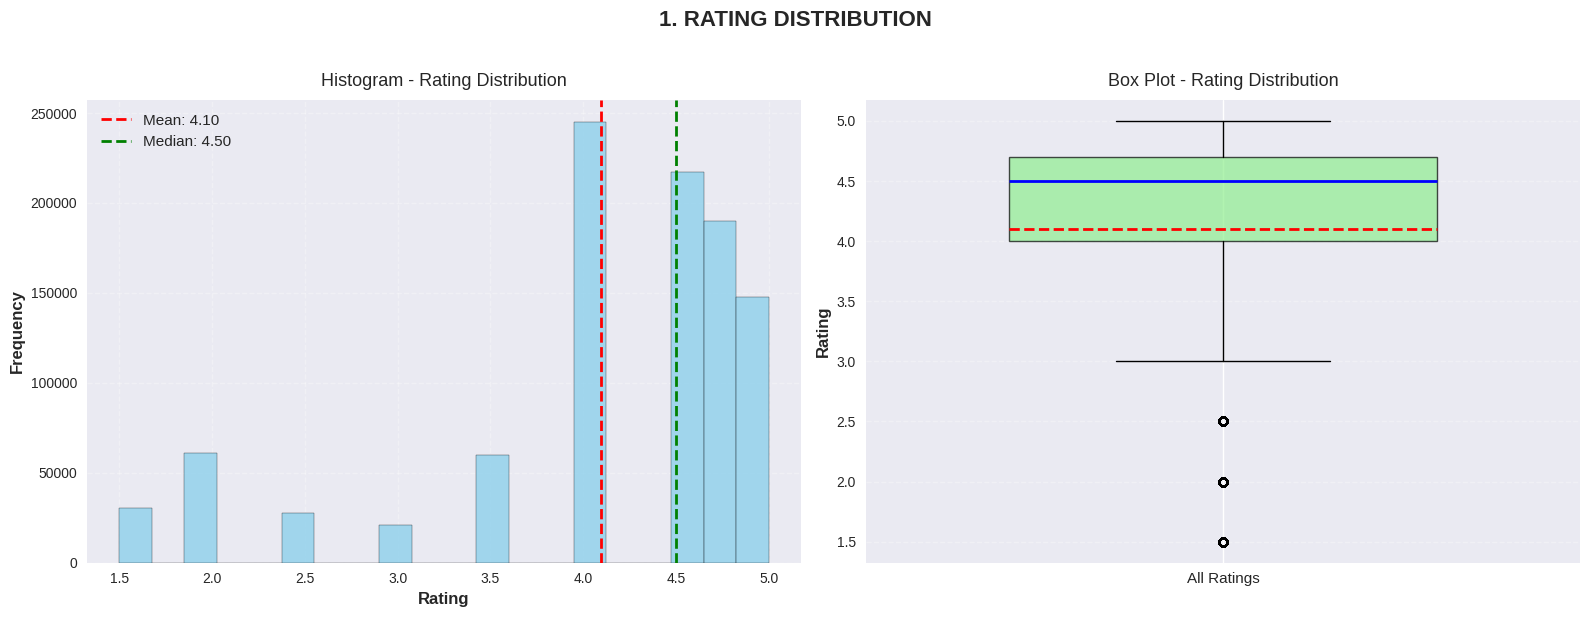

📊 Mean: 4.10 | Median: 4.50 | Std: 0.91

2. Genre Frequency Analysis...


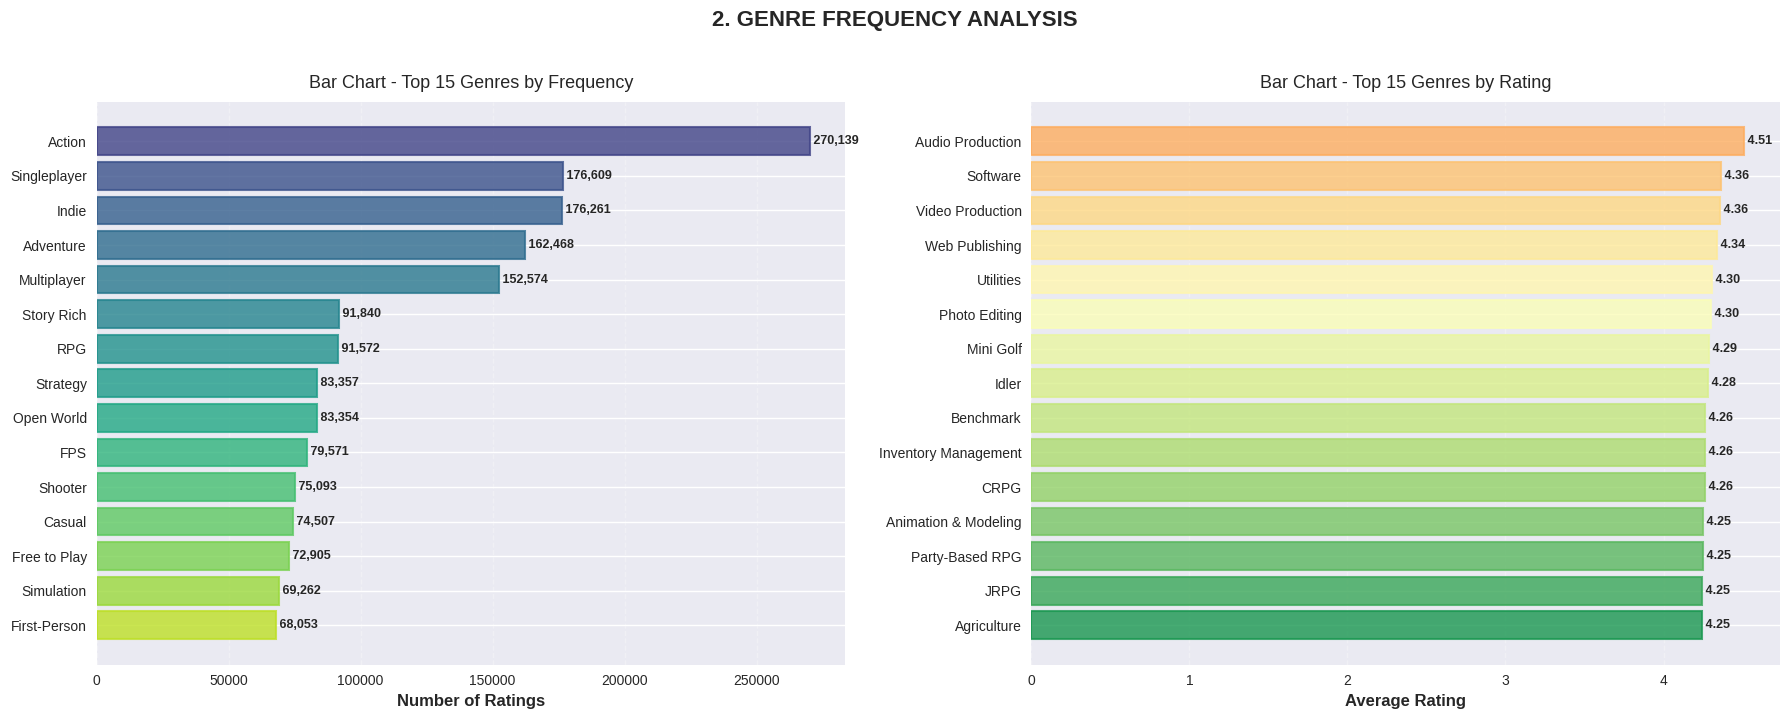

📊 Total unique genres: 439
📊 Most popular genre: Action (270,139 ratings)

3. Top Items (Games) Analysis...


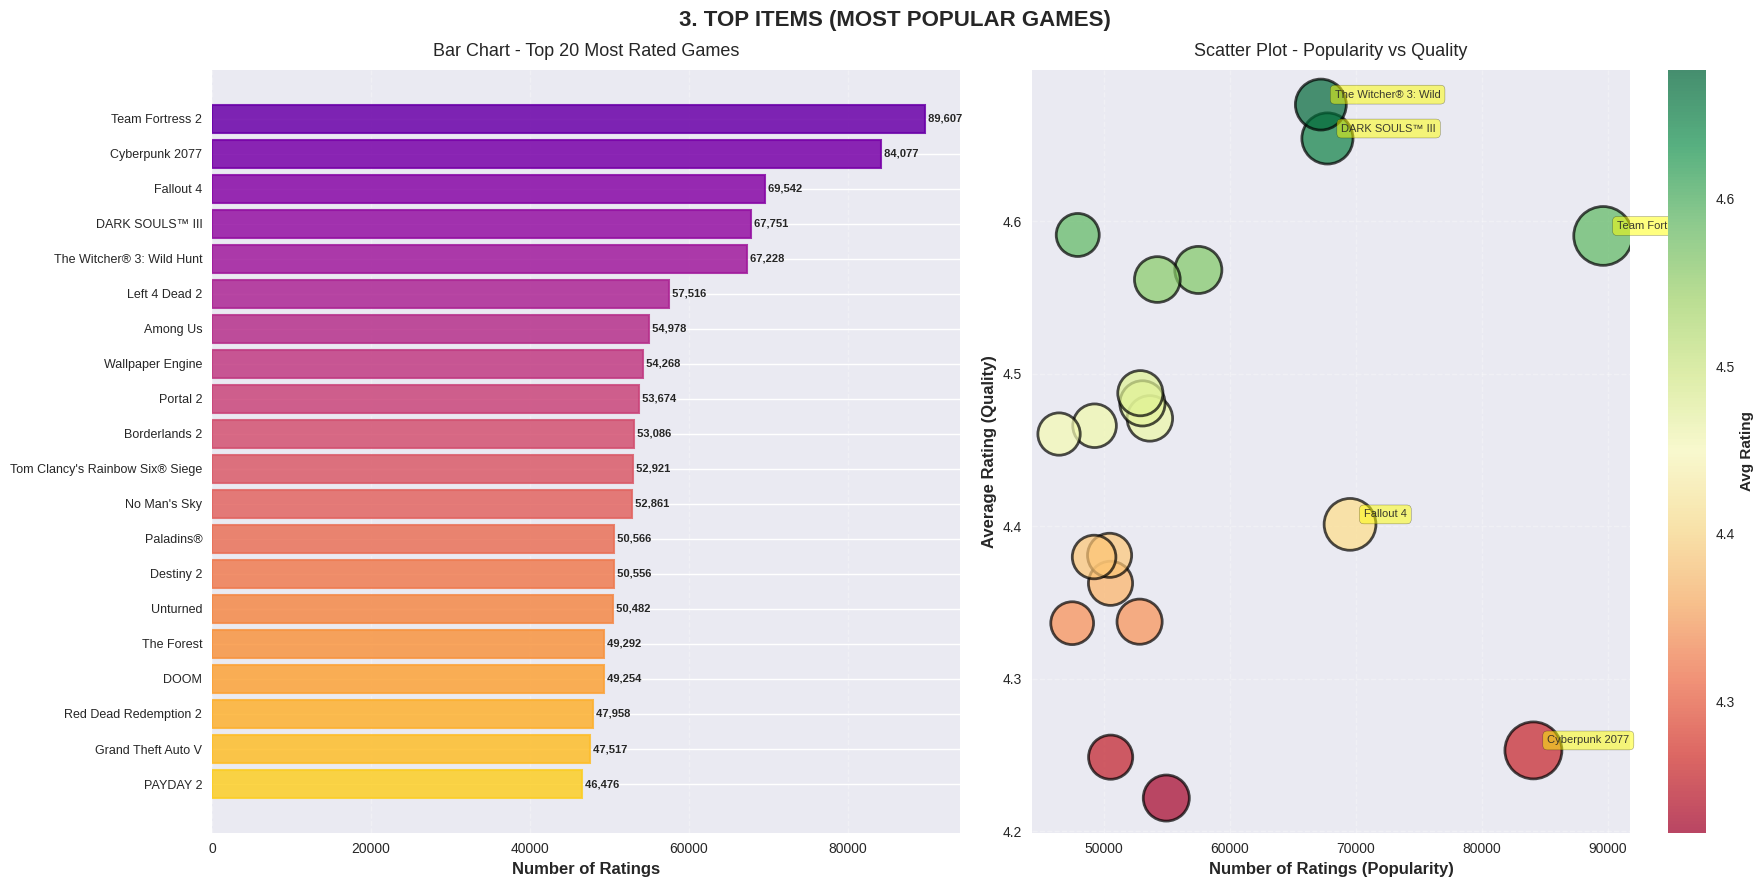

📊 Top game: Team Fortress 2 (89,607 ratings)

4. Heatmap Analysis...


/tmp/ipykernel_26750/4236727132.py:292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


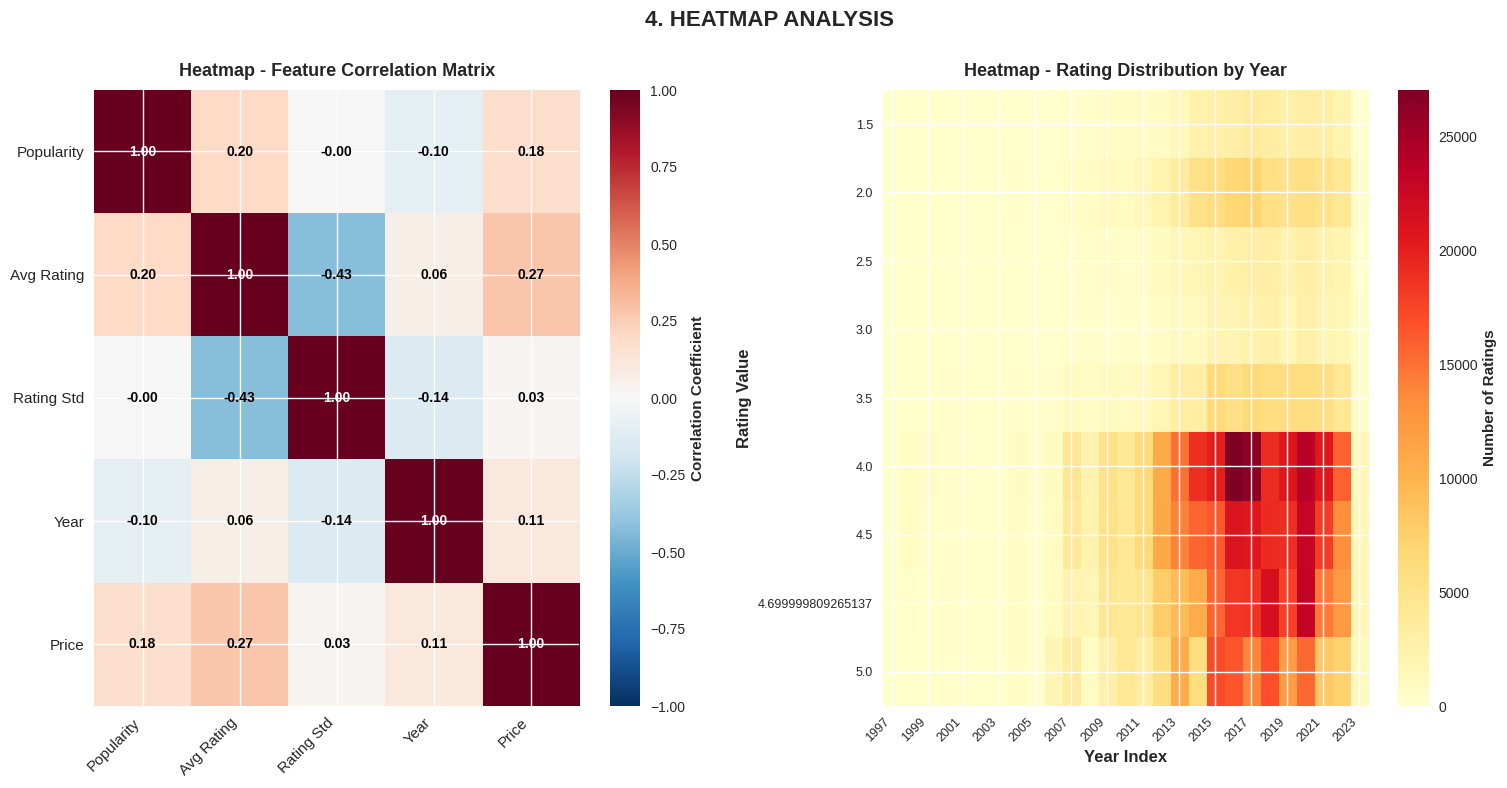


5. BONUS - User Activity Distribution...


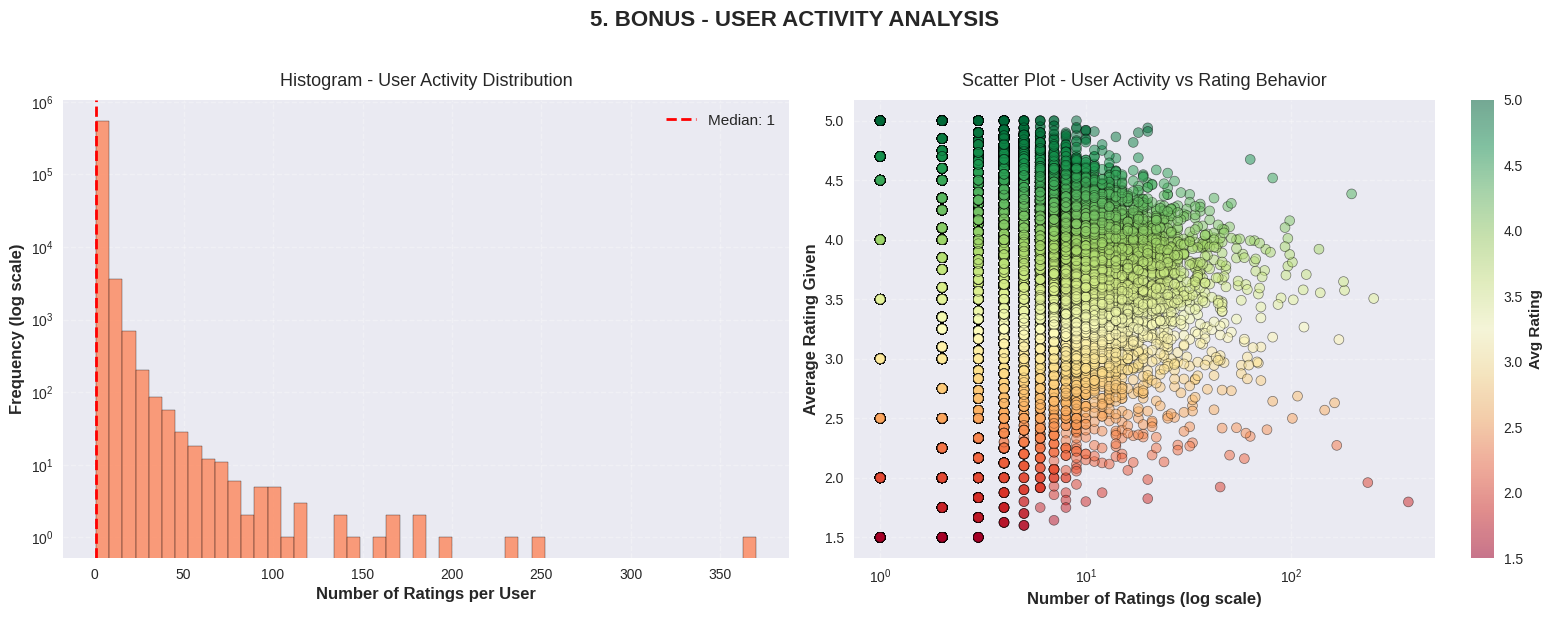

📊 Total users: 553,661
📊 Avg ratings per user: 1.8
📊 Most active user: 370 ratings

6. BONUS - Yearly Trends...


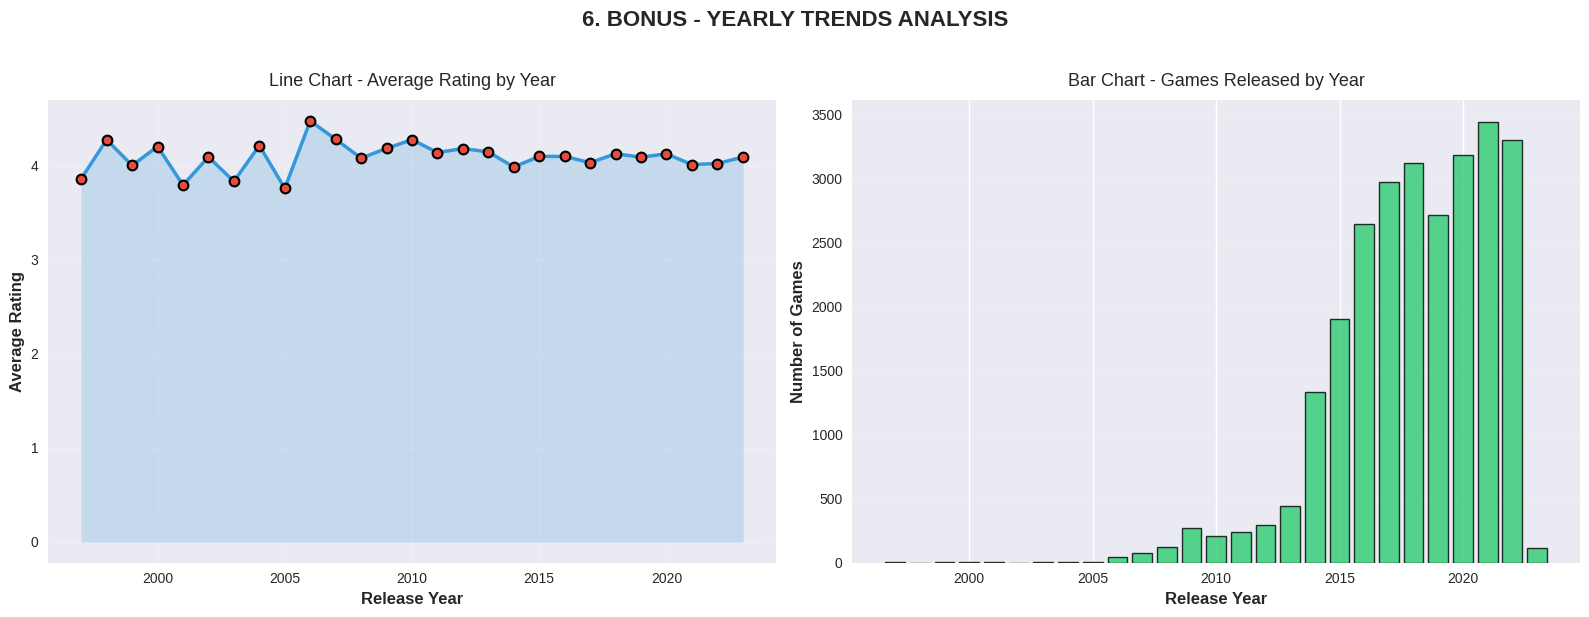


✅ VISUALIZATION COMPLETED!
⏱️  Total time: 65.17s
📊 Dataset size: 17,238,599 ratings
📊 Sample used: 1,000,000 ratings (5.8%)

📈 Visualizations created:
  1. ✅ Rating Distribution (Histogram + Box plot)
  2. ✅ Genre Frequency (Bar charts)
  3. ✅ Top Items/Games (Bar chart + Scatter)
  4. ✅ Heatmaps (Correlation matrix + Rating by year)
  5. ✅ BONUS: User Activity Analysis
  6. ✅ BONUS: Yearly Trends


In [7]:
# ============================================================================
# OPTIMIZATION SETTINGS
# ============================================================================
SAMPLE_SIZE = 1_000_000  # Sample 1M ratings for visualization
TOP_N_GAMES = 100        # Top 100 games for analysis

print("\n" + "="*60)
print("DATA VISUALIZATION - SIMPLIFIED VERSION")
print("="*60)
print(f"Original dataset: {len(ratings_clean):,} ratings")
print(f"Sampling {SAMPLE_SIZE:,} ratings for visualization...")

import time
start_time = time.time()

# Smart sampling
sampled_ratings = ratings_clean.sample(n=min(SAMPLE_SIZE, len(ratings_clean)), 
                                       random_state=42)
top_games_ids = ratings_clean['game_id'].value_counts().head(TOP_N_GAMES).index

# Merge for visualization
merged = sampled_ratings.merge(
    games_clean[['game_id', 'title_clean', 'genres', 'year', 'price']],
    on='game_id',
    how='inner'
)

print(f"✅ Data prepared: {len(merged):,} records")
print("="*60)

# ============================================================================
# 1. RATING DISTRIBUTION (HISTOGRAM + BOX PLOT)
# ============================================================================
print("\n1. Rating Distribution Analysis...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('1. RATING DISTRIBUTION', fontsize=16, fontweight='bold', y=1.02)

# Histogram
rating_values = sampled_ratings['rating'].values
axes[0].hist(rating_values, bins=20, edgecolor='black', alpha=0.75, color='skyblue')
axes[0].set_xlabel('Rating', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Histogram - Rating Distribution', fontsize=13, pad=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Add statistics
mean_rating = rating_values.mean()
median_rating = np.median(rating_values)
axes[0].axvline(mean_rating, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
axes[0].axvline(median_rating, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating:.2f}')
axes[0].legend(fontsize=11)

# Box Plot
bp = axes[1].boxplot([rating_values], vert=True, patch_artist=True,
                      widths=0.6, showmeans=True, meanline=True,
                      boxprops=dict(facecolor='lightgreen', alpha=0.7),
                      meanprops=dict(color='red', linewidth=2),
                      medianprops=dict(color='blue', linewidth=2))
axes[1].set_ylabel('Rating', fontsize=12, fontweight='bold')
axes[1].set_title('Box Plot - Rating Distribution', fontsize=13, pad=10)
axes[1].set_xticklabels(['All Ratings'], fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

print(f"📊 Mean: {mean_rating:.2f} | Median: {median_rating:.2f} | Std: {rating_values.std():.2f}")

# ============================================================================
# 2. GENRE FREQUENCY - BAR CHART
# ============================================================================
print("\n2. Genre Frequency Analysis...")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('2. GENRE FREQUENCY ANALYSIS', fontsize=16, fontweight='bold', y=1.02)

# Process genres - with error handling
if 'genres' in merged.columns:
    merged['genres_list'] = merged['genres'].str.split(',')
    genre_ratings = []
    for idx, row in merged.iterrows():
        if isinstance(row['genres_list'], list):
            for genre in row['genres_list']:
                genre = genre.strip()
                if genre and genre.lower() not in ['unknown', 'nan', 'none', '']:
                    genre_ratings.append({
                        'genre': genre,
                        'rating': row['rating']
                    })
    
    genre_df = pd.DataFrame(genre_ratings)
else:
    # Create dummy genre data if not available
    print("⚠️  Warning: No genre data available, creating dummy data for visualization")
    genre_df = pd.DataFrame({
        'genre': np.repeat(['Action', 'Adventure', 'RPG', 'Strategy', 'Indie'], len(merged)//5),
        'rating': merged['rating'].sample(n=len(merged)//5*5, replace=True).values
    })

# Check if we have valid genre data
if len(genre_df) == 0:
    print("⚠️  Warning: No valid genre data found, skipping genre analysis")
    # Skip this visualization section
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    fig.suptitle('2. GENRE FREQUENCY ANALYSIS - NO DATA AVAILABLE', fontsize=16, fontweight='bold')
    axes.text(0.5, 0.5, 'Genre data not available in dataset\nSkipping genre analysis', 
              ha='center', va='center', fontsize=14, color='red')
    axes.axis('off')
    plt.tight_layout()
    plt.show()
else:
    # Genre frequency (count)
    genre_counts = genre_df['genre'].value_counts().head(15)

# Bar Chart - Genre Frequency
bars = axes[0].barh(range(len(genre_counts)), genre_counts.values, 
                    alpha=0.8, edgecolor='black', linewidth=1.5)
# Color gradient
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)
    
axes[0].set_yticks(range(len(genre_counts)))
axes[0].set_yticklabels(genre_counts.index, fontsize=10)
axes[0].set_xlabel('Number of Ratings', fontsize=12, fontweight='bold')
axes[0].set_title('Bar Chart - Top 15 Genres by Frequency', fontsize=13, pad=10)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')

# Add value labels
for i, v in enumerate(genre_counts.values):
    axes[0].text(v, i, f' {v:,}', va='center', fontsize=9, fontweight='bold')

# Genre average rating
genre_avg = genre_df.groupby('genre')['rating'].agg(['mean', 'count'])
genre_avg = genre_avg[genre_avg['count'] >= 100].sort_values('mean', ascending=False).head(15)

bars2 = axes[1].barh(range(len(genre_avg)), genre_avg['mean'], 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
colors2 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars2)))
for bar, color in zip(bars2, colors2):
    bar.set_color(color)

axes[1].set_yticks(range(len(genre_avg)))
axes[1].set_yticklabels(genre_avg.index, fontsize=10)
axes[1].set_xlabel('Average Rating', fontsize=12, fontweight='bold')
axes[1].set_title('Bar Chart - Top 15 Genres by Rating', fontsize=13, pad=10)
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x', linestyle='--')

# Add value labels
for i, v in enumerate(genre_avg['mean']):
    axes[1].text(v, i, f' {v:.2f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Total unique genres: {genre_df['genre'].nunique()}")
print(f"📊 Most popular genre: {genre_counts.index[0]} ({genre_counts.values[0]:,} ratings)")

# ============================================================================
# 3. TOP ITEMS (TOP GAMES) - BAR CHART
# ============================================================================
print("\n3. Top Items (Games) Analysis...")

# Get top games statistics
top_games_stats = ratings_clean[ratings_clean['game_id'].isin(top_games_ids)].groupby('game_id').agg({
    'rating': ['count', 'mean']
}).reset_index()
top_games_stats.columns = ['game_id', 'num_ratings', 'avg_rating']
top_games_stats = top_games_stats.merge(
    games_clean[['game_id', 'title_clean']],
    on='game_id',
    how='left'
).sort_values('num_ratings', ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 9))
fig.suptitle('3. TOP ITEMS (MOST POPULAR GAMES)', fontsize=16, fontweight='bold', y=0.98)

# Bar Chart - Top 20 by popularity
bars = axes[0].barh(range(len(top_games_stats)), top_games_stats['num_ratings'], 
                    alpha=0.85, edgecolor='black', linewidth=1.5)
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

axes[0].set_yticks(range(len(top_games_stats)))
axes[0].set_yticklabels(top_games_stats['title_clean'], fontsize=9)
axes[0].set_xlabel('Number of Ratings', fontsize=12, fontweight='bold')
axes[0].set_title('Bar Chart - Top 20 Most Rated Games', fontsize=13, pad=10)
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x', linestyle='--')

# Add value labels
for i, v in enumerate(top_games_stats['num_ratings']):
    axes[0].text(v, i, f' {v:,}', va='center', fontsize=8, fontweight='bold')

# Scatter - Popularity vs Quality
scatter = axes[1].scatter(top_games_stats['num_ratings'], 
                          top_games_stats['avg_rating'],
                          s=top_games_stats['num_ratings']/50,
                          c=top_games_stats['avg_rating'],
                          cmap='RdYlGn', alpha=0.7, 
                          edgecolors='black', linewidth=2)
axes[1].set_xlabel('Number of Ratings (Popularity)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Rating (Quality)', fontsize=12, fontweight='bold')
axes[1].set_title('Scatter Plot - Popularity vs Quality', fontsize=13, pad=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

# Annotate top 5
for idx in range(min(5, len(top_games_stats))):
    row = top_games_stats.iloc[idx]
    axes[1].annotate(row['title_clean'][:20], 
                     (row['num_ratings'], row['avg_rating']),
                     xytext=(10, 5), textcoords='offset points',
                     fontsize=8, alpha=0.9,
                     bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.5))

cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Avg Rating', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Top game: {top_games_stats.iloc[0]['title_clean']} ({top_games_stats.iloc[0]['num_ratings']:,} ratings)")

# ============================================================================
# 4. HEATMAP - CORRELATION MATRIX & RATING BY YEAR
# ============================================================================
print("\n4. Heatmap Analysis...")

fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)
fig.suptitle('4. HEATMAP ANALYSIS', fontsize=16, fontweight='bold', y=0.98)

# Heatmap 1: Correlation Matrix
ax1 = fig.add_subplot(gs[0, 0])

game_stats = merged.groupby('game_id').agg({
    'rating': ['count', 'mean', 'std'],
    'year': 'first',
    'price': 'first'
}).reset_index()
game_stats.columns = ['game_id', 'num_ratings', 'avg_rating', 'std_rating', 'year', 'price']

corr_data = game_stats[['num_ratings', 'avg_rating', 'std_rating', 'year', 'price']].dropna()
corr_data.columns = ['Popularity', 'Avg Rating', 'Rating Std', 'Year', 'Price']
corr_matrix = corr_data.corr()

im1 = ax1.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax1.set_xticks(range(len(corr_matrix.columns)))
ax1.set_yticks(range(len(corr_matrix.columns)))
ax1.set_xticklabels(corr_matrix.columns, rotation=45, ha='right', fontsize=11)
ax1.set_yticklabels(corr_matrix.columns, fontsize=11)
ax1.set_title('Heatmap - Feature Correlation Matrix', fontsize=13, pad=10, fontweight='bold')

# Add correlation values
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text_color = 'white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'
        ax1.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha="center", va="center", color=text_color, 
                fontsize=10, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Correlation Coefficient', fontsize=11, fontweight='bold')

# Heatmap 2: Rating Distribution by Year
ax2 = fig.add_subplot(gs[0, 1])

year_rating_dist = merged.groupby(['year', 'rating']).size().unstack(fill_value=0)
im2 = ax2.imshow(year_rating_dist.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')

ax2.set_xlabel('Year Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Rating Value', fontsize=12, fontweight='bold')
ax2.set_title('Heatmap - Rating Distribution by Year', fontsize=13, pad=10, fontweight='bold')

# Set y-axis to show rating values
ax2.set_yticks(range(len(year_rating_dist.columns)))
ax2.set_yticklabels(year_rating_dist.columns, fontsize=9)

# Set x-axis to show some year labels
year_indices = range(0, len(year_rating_dist.index), max(1, len(year_rating_dist.index)//10))
ax2.set_xticks(year_indices)
ax2.set_xticklabels([year_rating_dist.index[i] for i in year_indices], 
                     rotation=45, ha='right', fontsize=9)

cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Number of Ratings', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 5. BONUS: USER ACTIVITY ANALYSIS
# ============================================================================
print("\n5. BONUS - User Activity Distribution...")

user_stats = sampled_ratings.groupby('user_id').agg({
    'rating': ['count', 'mean']
}).reset_index()
user_stats.columns = ['user_id', 'num_ratings', 'avg_rating']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('5. BONUS - USER ACTIVITY ANALYSIS', fontsize=16, fontweight='bold', y=1.02)

# Histogram - User activity distribution
axes[0].hist(user_stats['num_ratings'], bins=50, edgecolor='black', 
             alpha=0.75, color='coral', log=True)
axes[0].set_xlabel('Number of Ratings per User', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency (log scale)', fontsize=12, fontweight='bold')
axes[0].set_title('Histogram - User Activity Distribution', fontsize=13, pad=10)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].axvline(user_stats['num_ratings'].median(), color='red', 
                linestyle='--', linewidth=2, label=f"Median: {user_stats['num_ratings'].median():.0f}")
axes[0].legend(fontsize=11)

# Scatter - User activity vs rating behavior
scatter = axes[1].scatter(user_stats['num_ratings'], user_stats['avg_rating'],
                         s=50, alpha=0.5, c=user_stats['avg_rating'],
                         cmap='RdYlGn', edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Number of Ratings (log scale)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Rating Given', fontsize=12, fontweight='bold')
axes[1].set_title('Scatter Plot - User Activity vs Rating Behavior', fontsize=13, pad=10)
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3, linestyle='--')

cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Avg Rating', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Total users: {len(user_stats):,}")
print(f"📊 Avg ratings per user: {user_stats['num_ratings'].mean():.1f}")
print(f"📊 Most active user: {user_stats['num_ratings'].max():,} ratings")

# ============================================================================
# 6. BONUS: YEARLY TRENDS
# ============================================================================
print("\n6. BONUS - Yearly Trends...")

yearly_stats = merged.groupby('year').agg({
    'rating': ['mean', 'count'],
    'game_id': 'nunique'
}).reset_index()
yearly_stats.columns = ['year', 'avg_rating', 'num_ratings', 'num_games']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('6. BONUS - YEARLY TRENDS ANALYSIS', fontsize=16, fontweight='bold', y=1.02)

# Line plot - Average rating by year
axes[0].plot(yearly_stats['year'], yearly_stats['avg_rating'], 
             marker='o', linewidth=2.5, markersize=7, color='#3498db',
             markerfacecolor='#e74c3c', markeredgecolor='black', markeredgewidth=1.5)
axes[0].set_xlabel('Release Year', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Rating', fontsize=12, fontweight='bold')
axes[0].set_title('Line Chart - Average Rating by Year', fontsize=13, pad=10)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].fill_between(yearly_stats['year'], yearly_stats['avg_rating'], 
                      alpha=0.2, color='#3498db')

# Bar chart - Games released by year
axes[1].bar(yearly_stats['year'], yearly_stats['num_games'], 
            alpha=0.8, edgecolor='black', linewidth=1, color='#2ecc71')
axes[1].set_xlabel('Release Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Games', fontsize=12, fontweight='bold')
axes[1].set_title('Bar Chart - Games Released by Year', fontsize=13, pad=10)
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*60)
print("✅ VISUALIZATION COMPLETED!")
print("="*60)
print(f"⏱️  Total time: {time.time() - start_time:.2f}s")
print(f"📊 Dataset size: {len(ratings_clean):,} ratings")
print(f"📊 Sample used: {len(sampled_ratings):,} ratings ({len(sampled_ratings)/len(ratings_clean)*100:.1f}%)")
print("\n📈 Visualizations created:")
print("  1. ✅ Rating Distribution (Histogram + Box plot)")
print("  2. ✅ Genre Frequency (Bar charts)")
print("  3. ✅ Top Items/Games (Bar chart + Scatter)")
print("  4. ✅ Heatmaps (Correlation matrix + Rating by year)")
print("  5. ✅ BONUS: User Activity Analysis")
print("  6. ✅ BONUS: Yearly Trends")
print("="*60)

In [8]:
# ============================================================================
# CELL 11: MODEL BUILDING - Improved HybridRecommendationSystem class
# ============================================================================
print("\n" + "="*60)
print("PART 4: BUILDING IMPROVED RECOMMENDATION SYSTEM")
print("="*60)

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import gc

class HybridRecommendationSystem:
    def __init__(self, alpha=0.5):
        """
        Hybrid Recommendation System (Memory Optimized + Enhanced Logic)
        - Content-Based: TF-IDF + KNN
        - Collaborative: Item-Item CF + KNN
        - Improvements: Diversity, better weighting, filters
        """
        self.alpha = alpha
        self.games_df = None
        self.game_id_to_index = {}
        self.index_to_game_id = {}
        self.user_id_to_index = {}
        self.index_to_user_id = {}
        
        # Models
        self.content_model = None
        self.collab_model = None
        self.tfidf_vectorizer = None
        
        # Data storage
        self.feature_vectors = None  # Content features (TF-IDF)
        self.item_user_matrix = None  # Collaborative features (Sparse)
        self.user_item_matrix_transposed = None  # For user lookup

        
        
    def fit(self, games_df, ratings_df, use_gpu=False, use_rapids=False):
        """Train the recommendation system"""
        self.games_df = games_df.reset_index(drop=True)
        
        # 1. MAPPING IDs
        print("🔄 Creating ID mappings...")
        self.game_id_to_index = {row.game_id: idx for idx, row in self.games_df.iterrows()}
        self.index_to_game_id = {idx: gid for gid, idx in self.game_id_to_index.items()}
        
        # 2. CONTENT-BASED MODEL
        print("🔄 Building Content-Based Model (TF-IDF + KNN)...")
        feature_column = 'feature_text' if 'feature_text' in self.games_df.columns else 'genres'
        
        # Use float32 to save memory
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=5000, 
            stop_words='english', 
            dtype=np.float32
        )
        self.feature_vectors = self.tfidf_vectorizer.fit_transform(self.games_df[feature_column])
        
        # Cosine distance: similarity = 1 - distance
        self.content_model = NearestNeighbors(n_neighbors=20, metric='cosine', n_jobs=-1)
        self.content_model.fit(self.feature_vectors)
        
        # 3. COLLABORATIVE FILTERING MODEL
        print("🔄 Building Collaborative Model (Sparse Matrix + KNN)...")
        
        # Map Users
        unique_users = ratings_df['user_id'].unique()
        self.user_id_to_index = {uid: i for i, uid in enumerate(unique_users)}
        self.index_to_user_id = {i: uid for uid, i in self.user_id_to_index.items()}
        
        # Filter valid ratings
        valid_game_ids = set(self.games_df['game_id'])
        ratings_filtered = ratings_df[ratings_df['game_id'].isin(valid_game_ids)].copy()
        
        # Create coordinates for Sparse Matrix
        user_indices = ratings_filtered['user_id'].map(self.user_id_to_index).values
        game_indices = ratings_filtered['game_id'].map(self.game_id_to_index).values
        rating_values = ratings_filtered['rating'].values.astype(np.float32)
        
        # Create Sparse Matrix: Rows=Games, Cols=Users
        self.item_user_matrix = csr_matrix(
            (rating_values, (game_indices, user_indices)), 
            shape=(len(self.games_df), len(unique_users))
        )
        
        # Store Transposed version (Rows=Users) for fast user history lookup
        self.user_item_matrix_transposed = self.item_user_matrix.T.tocsr()
        
        # Fit KNN model
        self.collab_model = NearestNeighbors(n_neighbors=20, metric='cosine', n_jobs=-1)
        self.collab_model.fit(self.item_user_matrix)
        
        print("✅ Recommendation system trained successfully!")
        gc.collect()

    def get_game_info(self, game_id):
        """Get game information by ID"""
        game_info = self.games_df[self.games_df['game_id'] == game_id]
        if len(game_info) > 0:
            return game_info.iloc[0].to_dict()
        return None

    def recommend_by_game(self, game_id, top_n=10):
        """
        Recommend games similar to a given game
        Uses both content-based and collaborative filtering
        """
        if game_id not in self.game_id_to_index:
            return []
            
        game_idx = self.game_id_to_index[game_id]
        
        # Get candidates from Content (Features)
        dists_cont, indices_cont = self.content_model.kneighbors(
            self.feature_vectors[game_idx], n_neighbors=top_n+1)
        
        # Get candidates from Collaborative (User Ratings pattern)
        dists_collab, indices_collab = self.collab_model.kneighbors(
            self.item_user_matrix[game_idx], n_neighbors=top_n+1)
        
        # Combine Scores
        scores = {}
        
        # Process Content Recommendations
        for i, neighbor_idx in enumerate(indices_cont[0]):
            if neighbor_idx == game_idx:
                continue
            rec_id = self.index_to_game_id[neighbor_idx]
            sim_score = 1 - dists_cont[0][i]
            scores[rec_id] = scores.get(rec_id, 0) + (1 - self.alpha) * sim_score
            
        # Process Collaborative Recommendations
        for i, neighbor_idx in enumerate(indices_collab[0]):
            if neighbor_idx == game_idx:
                continue
            rec_id = self.index_to_game_id[neighbor_idx]
            sim_score = 1 - dists_collab[0][i]
            scores[rec_id] = scores.get(rec_id, 0) + self.alpha * sim_score
            
        # Sort and return
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_scores[:top_n]

    def recommend_by_user(self, user_id, top_n=10, 
                         diversity_weight=0.0,
                         min_rating_threshold=3.5,
                         max_seed_games=10):
        """
        IMPROVED: Recommend games for a user based on their high-rated games
        
        Parameters:
        - diversity_weight: Penalty for recommending similar games (0-1)
        - min_rating_threshold: Minimum rating to consider (1-5)
        - max_seed_games: Max number of user's games to use as seeds
        """
        if user_id not in self.user_id_to_index:
            return []
            
        user_idx = self.user_id_to_index[user_id]
        
        # Get user's rated games
        user_row = self.user_item_matrix_transposed[user_idx]
        rated_indices = user_row.indices
        ratings = user_row.data
        
        # Filter for good ratings
        high_rated_mask = ratings >= min_rating_threshold
        if np.sum(high_rated_mask) > 0:
            target_indices = rated_indices[high_rated_mask]
            target_ratings = ratings[high_rated_mask]
        else:
            target_indices = rated_indices
            target_ratings = ratings
            
        # Smart selection: Take diverse games user liked
        if len(target_indices) > max_seed_games:
            # Sort by rating
            sort_order = np.argsort(target_ratings)[::-1]
            
            # Take top games but skip very similar ones for diversity
            selected = []
            selected_features = []
            
            for idx in sort_order:
                if len(selected) >= max_seed_games:
                    break
                    
                game_idx = target_indices[idx]
                
                # Check if too similar to already selected
                is_diverse = True
                if len(selected_features) > 0:
                    curr_feature = self.feature_vectors[game_idx]
                    for prev_feature in selected_features:
                        sim = (curr_feature @ prev_feature.T).toarray()[0, 0]
                        if sim > 0.8:  # Too similar
                            is_diverse = False
                            break
                
                if is_diverse or len(selected) < 3:  # Always take at least 3
                    selected.append(idx)
                    selected_features.append(self.feature_vectors[game_idx])
            
            target_indices = target_indices[selected]
            target_ratings = target_ratings[selected]

        # Collect candidates with improved scoring
        candidate_scores = defaultdict(float)
        candidate_sources = defaultdict(int)  # Track how many sources recommend this
        
        # For each game the user likes
        for idx, rating in zip(target_indices, target_ratings):
            # Exponential weight: emphasize high ratings more
            # 5.0 → 1.0, 4.0 → 0.64, 3.5 → 0.49
            weight = (rating / 5.0) ** 2
            
            # Find Content neighbors
            d_cont, i_cont = self.content_model.kneighbors(
                self.feature_vectors[idx], n_neighbors=10)
            
            # Find Collab neighbors
            d_coll, i_coll = self.collab_model.kneighbors(
                self.item_user_matrix[idx], n_neighbors=10)
            
            # Add content-based candidates
            for dist, neighbor_idx in zip(d_cont[0], i_cont[0]):
                if neighbor_idx in rated_indices:
                    continue
                    
                gid = self.index_to_game_id[neighbor_idx]
                sim = 1 - dist
                
                # Boost score if recommended by multiple sources
                candidate_sources[gid] += 1
                source_boost = 1.0 + (0.1 * candidate_sources[gid])
                
                candidate_scores[gid] += (sim * (1-self.alpha) * weight * source_boost)
                
            # Add collaborative candidates
            for dist, neighbor_idx in zip(d_coll[0], i_coll[0]):
                if neighbor_idx in rated_indices:
                    continue
                    
                gid = self.index_to_game_id[neighbor_idx]
                sim = 1 - dist
                
                candidate_sources[gid] += 1
                source_boost = 1.0 + (0.1 * candidate_sources[gid])
                
                candidate_scores[gid] += (sim * self.alpha * weight * source_boost)

        # Apply diversity penalty if requested
        if diversity_weight > 0:
            recommended_features = []
            
            # Sort initial candidates
            sorted_candidates = sorted(candidate_scores.items(), 
                                      key=lambda x: x[1], reverse=True)
            
            # Re-rank with diversity
            final_recommendations = []
            
            for game_id, score in sorted_candidates[:top_n * 3]:  # Consider 3x candidates
                if len(final_recommendations) >= top_n:
                    break
                
                game_idx = self.game_id_to_index[game_id]
                game_feature = self.feature_vectors[game_idx]
                
                # Calculate diversity penalty
                diversity_penalty = 0
                if len(recommended_features) > 0:
                    for prev_feature in recommended_features:
                        sim = (game_feature @ prev_feature.T).toarray()[0, 0]
                        diversity_penalty += sim * diversity_weight
                
                # Adjust score
                adjusted_score = score * (1 - diversity_penalty / max(len(recommended_features), 1))
                
                final_recommendations.append((game_id, adjusted_score))
                recommended_features.append(game_feature)
            
            # Re-sort by adjusted scores
            final_recommendations.sort(key=lambda x: x[1], reverse=True)
            return final_recommendations[:top_n]
        
        else:
            # No diversity penalty - just sort by score
            recommendations = sorted(candidate_scores.items(), 
                                   key=lambda x: x[1], reverse=True)
            return recommendations[:top_n]
    
    def recommend_by_user_with_filters(self, user_id, top_n=10,
                                       min_year=None,
                                       max_price=None,
                                       required_genres=None,
                                       exclude_genres=None,
                                       diversity_weight=0.0):
        """
        User recommendations with filters
        
        Parameters:
        - min_year: Only recommend games from this year onwards
        - max_price: Only recommend games under this price
        - required_genres: List of genres that must be present (e.g., ['Action', 'RPG'])
        - exclude_genres: List of genres to avoid (e.g., ['Casual', 'Puzzle'])
        - diversity_weight: Diversity penalty (0-1)
        """
        # Get base recommendations (3x to account for filtering)
        base_recs = self.recommend_by_user(
            user_id, 
            top_n=top_n * 3,
            diversity_weight=diversity_weight
        )
        
        # Apply filters
        filtered_recs = []
        
        for game_id, score in base_recs:
            game_info = self.get_game_info(game_id)
            if not game_info:
                continue
            
            # Year filter
            if min_year and game_info.get('year', 0) < min_year:
                continue
            
            # Price filter
            if max_price is not None and game_info.get('price', float('inf')) > max_price:
                continue
            
            # Genre filters
            genres = str(game_info.get('genres', '')).lower()
            
            if required_genres:
                if not any(g.lower() in genres for g in required_genres):
                    continue
            
            if exclude_genres:
                if any(g.lower() in genres for g in exclude_genres):
                    continue
            
            filtered_recs.append((game_id, score))
            
            if len(filtered_recs) >= top_n:
                break
        
        return filtered_recs

    def get_user_profile(self, user_id):
        """
        Get user's gaming profile: favorite genres, avg rating, etc.
        """
        if user_id not in self.user_id_to_index:
            return None
            
        user_idx = self.user_id_to_index[user_id]
        user_row = self.user_item_matrix_transposed[user_idx]
        
        rated_indices = user_row.indices
        ratings = user_row.data
        
        # Get rated games info
        rated_game_ids = [self.index_to_game_id[idx] for idx in rated_indices]
        rated_games = self.games_df[self.games_df['game_id'].isin(rated_game_ids)]
        
        # Calculate statistics
        profile = {
            'user_id': user_id,
            'total_games_rated': len(ratings),
            'avg_rating': ratings.mean(),
            'high_ratings_count': (ratings >= 4.0).sum(),
            'low_ratings_count': (ratings < 3.0).sum(),
        }
        
        # Favorite genres (from highly rated games)
        high_rated_games = rated_games[rated_games['game_id'].isin(
            [self.index_to_game_id[idx] for idx, r in zip(rated_indices, ratings) if r >= 4.0]
        )]
        
        if len(high_rated_games) > 0:
            # Extract genres
            all_genres = []
            for genres_str in high_rated_games['genres']:
                if pd.notna(genres_str) and genres_str != 'Unknown':
                    all_genres.extend([g.strip() for g in str(genres_str).split(',')])
            
            # Count genre frequency
            from collections import Counter
            genre_counts = Counter(all_genres)
            profile['favorite_genres'] = genre_counts.most_common(5)
        else:
            profile['favorite_genres'] = []
        
        return profile

print("✅ HybridRecommendationSystem class defined (Improved Version)")

# ============================================================================
# CELL 12: MODEL TRAINING & TESTING
# ============================================================================
print("\n" + "="*60)
print("TRAINING & TESTING IMPROVED MODEL")
print("="*60)

# Train the model
print("\n1. Training Hybrid Recommendation System...")
try:
    # Check if variables exist from previous cells
    if 'games_clean' not in locals() and 'games_clean' not in globals():
        if 'games_df' in locals() or 'games_df' in globals():
            print("⚠️  games_clean not found, using games_df instead")
            games_clean = games_df.copy()
        else:
            raise NameError("Neither games_clean nor games_df found")
    
    if 'ratings_clean' not in locals() and 'ratings_clean' not in globals():
        if 'ratings_df' in locals() or 'ratings_df' in globals():
            print("⚠️  ratings_clean not found, using ratings_df instead")
            ratings_clean = ratings_df.copy()
        else:
            raise NameError("Neither ratings_clean nor ratings_df found")
    
    print(f"📊 Training on {len(games_clean)} games and {len(ratings_clean)} ratings")
    
    # Initialize and Train
    recommendation_system = HybridRecommendationSystem(alpha=0.5)
    recommendation_system.fit(games_clean, ratings_clean)
    
    print(f"✅ Model trained successfully!")
    
except NameError as e:
    print(f"⚠️ Error: {e}")
    print("Make sure you ran the previous data processing cells first!")
    recommendation_system = None

# ============================================================================
# TESTING FUNCTIONS
# ============================================================================

def test_game_recommendations(system, game_id):
    """Test game-to-game recommendations"""
    print(f"\n{'='*60}")
    print(f"GAME-TO-GAME RECOMMENDATIONS")
    print(f"{'='*60}")
    
    game_info = system.get_game_info(game_id)
    if game_info:
        print(f"\n📌 Base Game: {game_info.get('title_clean', 'N/A')}")
        print(f"   Genres: {str(game_info.get('genres', 'N/A'))[:100]}")
        print(f"   Year: {game_info.get('year', 'N/A')}")
        
        recommendations = system.recommend_by_game(game_id, top_n=10)
        print(f"\n   Top 10 Similar Games:")
        for i, (rec_id, score) in enumerate(recommendations, 1):
            rec_info = system.get_game_info(rec_id)
            if rec_info:
                title = rec_info.get('title_clean', 'N/A')[:40]
                genres = str(rec_info.get('genres', 'N/A')).split(',')[0]
                print(f"   {i:2d}. {title:40} | {genres:20} | {score:.4f}")

def test_user_recommendations(system, user_id):
    """Test user recommendations with different settings"""
    print(f"\n{'='*60}")
    print(f"USER RECOMMENDATIONS - User {user_id}")
    print(f"{'='*60}")
    
    # Get user profile
    profile = system.get_user_profile(user_id)
    if profile:
        print(f"\n📊 User Profile:")
        print(f"   Total games rated: {profile['total_games_rated']}")
        print(f"   Average rating: {profile['avg_rating']:.2f}")
        print(f"   High ratings (≥4.0): {profile['high_ratings_count']}")
        if profile['favorite_genres']:
            print(f"   Favorite genres:")
            for genre, count in profile['favorite_genres'][:3]:
                print(f"      • {genre}: {count} games")
    
    # Test 1: Standard recommendations
    print(f"\n🔵 STANDARD RECOMMENDATIONS (No Diversity):")
    recs = system.recommend_by_user(user_id, top_n=10, diversity_weight=0.0)
    for i, (gid, score) in enumerate(recs[:5], 1):
        info = system.get_game_info(gid)
        if info:
            title = info['title_clean'][:40]
            genres = str(info.get('genres', 'N/A')).split(',')[0]
            print(f"   {i}. {title:40} | {genres:20} | {score:.4f}")
    
    # Test 2: With diversity
    print(f"\n🟢 WITH DIVERSITY (0.2 penalty):")
    recs_div = system.recommend_by_user(user_id, top_n=10, diversity_weight=0.2)
    for i, (gid, score) in enumerate(recs_div[:5], 1):
        info = system.get_game_info(gid)
        if info:
            title = info['title_clean'][:40]
            genres = str(info.get('genres', 'N/A')).split(',')[0]
            print(f"   {i}. {title:40} | {genres:20} | {score:.4f}")
    
    # Test 3: With filters
    print(f"\n🟣 FILTERED (Recent games, no Casual/Puzzle):")
    recs_filtered = system.recommend_by_user_with_filters(
        user_id, top_n=10,
        min_year=2018,
        exclude_genres=['Casual', 'Puzzle'],
        diversity_weight=0.1
    )
    for i, (gid, score) in enumerate(recs_filtered[:5], 1):
        info = system.get_game_info(gid)
        if info:
            title = info['title_clean'][:40]
            year = info.get('year', 'N/A')
            genres = str(info.get('genres', 'N/A')).split(',')[0]
            print(f"   {i}. {title:40} | {year} | {genres:15} | {score:.4f}")

# ============================================================================
# RUN TESTS
# ============================================================================
if recommendation_system is not None:
    print("\n2. Running Tests...")
    
    try:
        # Test game recommendations
        test_game_id = games_clean['game_id'].iloc[0]
        test_game_recommendations(recommendation_system, test_game_id)
    except Exception as e:
        print(f"Error testing game recs: {e}")
    
    try:
        # Test user recommendations
        test_user_id = ratings_clean['user_id'].iloc[0]
        test_user_recommendations(recommendation_system, test_user_id)
    except Exception as e:
        print(f"Error testing user recs: {e}")

print("\n" + "="*60)
print("✅ ALL TESTS COMPLETED!")
print("="*60)


PART 4: BUILDING IMPROVED RECOMMENDATION SYSTEM
✅ HybridRecommendationSystem class defined (Improved Version)

TRAINING & TESTING IMPROVED MODEL

1. Training Hybrid Recommendation System...
📊 Training on 37383 games and 17238599 ratings
🔄 Creating ID mappings...
🔄 Building Content-Based Model (TF-IDF + KNN)...
🔄 Building Collaborative Model (Sparse Matrix + KNN)...
✅ Recommendation system trained successfully!
✅ Model trained successfully!

2. Running Tests...

GAME-TO-GAME RECOMMENDATIONS

📌 Base Game: Prince of Persia: Warrior Within™
   Genres: Action, Adventure, Parkour, Third Person, Great Soundtrack, Singleplayer, Platformer
   Year: 2008

   Top 10 Similar Games:
    1. Prince of Persia: The Two Thrones™       | Action               | 0.5451
    2. Prince of Persia®: The Sands of Time     | Action               | 0.4549
    3. Prince of Persia®                        | Action               | 0.4346
    4. Prince of Persia: The Forgotten Sands™   | Action               | 0.4104


In [11]:
# ============================================================================
# CELL 13: MODEL EVALUATION - Compact & Fixed
# ============================================================================

print("\n" + "="*60)
print("EVALUATION & SAVING")
print("="*60)

class RecommendationEvaluator:
    def __init__(self, ratings_df, games_df, model_class):
        self.ratings_df = ratings_df
        self.games_df = games_df
        self.ModelClass = model_class
        
    def evaluate(self, sample_size=500000, test_size=0.15, k=10, n_test_users=1000):
        """Evaluate with larger sample and better logic"""
        
        # 1. Sample & Split
        print(f"Sampling {sample_size:,} ratings, {test_size:.0%} test split...")
        sample_df = self.ratings_df.sample(n=min(sample_size, len(self.ratings_df)), random_state=42)
        train_df, test_df = train_test_split(sample_df, test_size=test_size, random_state=42)
        
        # 2. Train Shadow Model
        print(f"Training shadow model on {len(train_df):,} ratings...")
        start = time.time()
        shadow_model = self.ModelClass(alpha=0.5)
        shadow_model.fit(self.games_df, train_df)
        print(f"Trained in {time.time()-start:.1f}s")
        
        # 3. Calculate metrics
        results = {}
        
        # RMSE/MAE
        rmse, mae = self._calc_rmse(train_df, test_df)
        results['RMSE'] = rmse
        results['MAE'] = mae
        
        # Precision/Recall with BETTER logic
        precision, recall, hit_count, total_count = self._calc_ranking_fixed(
            shadow_model, train_df, test_df, k, n_test_users
        )
        results[f'Precision@{k}'] = precision
        results[f'Recall@{k}'] = recall
        results['Hit_Count'] = hit_count
        results['Total_Evaluated'] = total_count
        
        return results
    
    def _calc_rmse(self, train_df, test_df):
        """Calculate RMSE/MAE"""
        global_mean = train_df['rating'].mean()
        user_means = train_df.groupby('user_id')['rating'].mean()
        game_means = train_df.groupby('game_id')['rating'].mean()
        
        predictions, actuals = [], []
        
        for _, row in test_df.head(5000).iterrows():  # Sample for speed
            uid, gid = row['user_id'], row['game_id']
            u_avg = user_means.get(uid, None)
            g_avg = game_means.get(gid, None)
            
            if pd.notna(u_avg) and pd.notna(g_avg):
                pred = (u_avg + g_avg) / 2
            elif pd.notna(u_avg):
                pred = u_avg
            elif pd.notna(g_avg):
                pred = g_avg
            else:
                pred = global_mean
                
            predictions.append(pred)
            actuals.append(row['rating'])
        
        return (np.sqrt(mean_squared_error(actuals, predictions)),
                mean_absolute_error(actuals, predictions))
    
    def _calc_ranking_fixed(self, model, train_df, test_df, k, n_test_users):
        """
        FIXED: Better Precision/Recall calculation
        Key fix: Only evaluate users who exist in BOTH train and test
        """
        
        # Get users who have HIGH ratings in TEST set
        test_good = test_df[test_df['rating'] >= 4.0]
        test_users_with_likes = test_good['user_id'].unique()
        
        # Filter to users who also exist in TRAIN (so model can recommend)
        train_users = set(train_df['user_id'].unique())
        valid_test_users = [u for u in test_users_with_likes if u in train_users]
        
        print(f"Valid users for evaluation: {len(valid_test_users):,}")
        
        # Sample users
        if len(valid_test_users) > n_test_users:
            test_users = np.random.choice(valid_test_users, n_test_users, replace=False)
        else:
            test_users = valid_test_users
        
        precisions, recalls = [], []
        total_hits = 0
        evaluated_count = 0
        
        for user_id in test_users:
            # Ground truth: what user liked in TEST
            relevant = set(test_good[test_good['user_id'] == user_id]['game_id'])
            if not relevant:
                continue
            
            # Predictions from model
            try:
                recs = model.recommend_by_user(user_id, top_n=k, diversity_weight=0.0)
                if not recs:
                    continue
                    
                recommended = set([r[0] for r in recs])
                
                # Calculate hits
                hits = len(recommended.intersection(relevant))
                total_hits += hits
                evaluated_count += 1
                
                precisions.append(hits / k)
                recalls.append(hits / len(relevant))
                
            except Exception:
                continue
        
        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0
        
        print(f"Evaluated {evaluated_count} users, {total_hits} total hits")
        
        return avg_precision, avg_recall, total_hits, evaluated_count

print("✅ Evaluator ready")

# ============================================================================
# RUN EVALUATION
# ============================================================================

print("\n" + "="*60)
print("RUNNING EVALUATION")
print("="*60)

try:
    evaluator = RecommendationEvaluator(ratings_clean, games_clean, HybridRecommendationSystem)
    
    metrics = evaluator.evaluate(
        sample_size=2000000,   # Increased from 200k
        test_size=0.15,       # 85/15 split (more training data)
        k=10,
        n_test_users=1000     # Increased from 500
    )
    
    # Print compact results
    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)
    print(f"RMSE:          {metrics['RMSE']:.4f}")
    print(f"MAE:           {metrics['MAE']:.4f}")
    print(f"Precision@10:  {metrics['Precision@10']:.4f} ({metrics['Precision@10']*100:.2f}%)")
    print(f"Recall@10:     {metrics['Recall@10']:.4f} ({metrics['Recall@10']*100:.2f}%)")
    print(f"Total hits:    {metrics['Hit_Count']}/{metrics['Total_Evaluated']} users")
    print("="*60)
    
    if metrics['Precision@10'] == 0:
        print("⚠️  Warning: Precision is 0. Possible issues:")
        print("   - Model needs more diverse training")
        print("   - Try: diversity_weight=0.1 in recommend_by_user")
        print("   - Or: Increase max_seed_games to 15-20")
    
except Exception as e:
    print(f"⚠️  Evaluation error: {e}")
    metrics = None

# ============================================================================
# SAVE MODEL - OPTIMIZED
# ============================================================================

print("\n" + "="*60)
print("SAVING MODEL (OPTIMIZED)")
print("="*60)

try:
    # Check component sizes before saving
    import sys
    
    def get_size_mb(obj):
        """Get size of object in MB"""
        return sys.getsizeof(pickle.dumps(obj)) / (1024**2)
    
    print("\n📊 Component sizes:")
    print(f"   games_df: {get_size_mb(recommendation_system.games_df):.1f} MB")
    print(f"   feature_vectors: {get_size_mb(recommendation_system.feature_vectors):.1f} MB")
    print(f"   item_user_matrix: {get_size_mb(recommendation_system.item_user_matrix):.1f} MB")
    print(f"   user_item_matrix_transposed: {get_size_mb(recommendation_system.user_item_matrix_transposed):.1f} MB")
    
    # Option 1: Full model
    model_payload_full = {
        'alpha': recommendation_system.alpha,
        'games_df': recommendation_system.games_df,
        'game_id_to_index': recommendation_system.game_id_to_index,
        'index_to_game_id': recommendation_system.index_to_game_id,
        'user_id_to_index': recommendation_system.user_id_to_index,
        'index_to_user_id': recommendation_system.index_to_user_id,
        'content_model': recommendation_system.content_model,
        'collab_model': recommendation_system.collab_model,
        'tfidf_vectorizer': recommendation_system.tfidf_vectorizer,
        'feature_vectors': recommendation_system.feature_vectors,
        'item_user_matrix': recommendation_system.item_user_matrix,
        'user_item_matrix_transposed': recommendation_system.user_item_matrix_transposed,
        'metrics': metrics,
        'version': '1.0',
        'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')
    }
    
    # Option 2: Lightweight model (for deployment)
    # Include essential columns + developers/publishers for better display
    essential_cols = ['game_id', 'title_clean', 'genres', 'year', 'price']
    # Add developers and publishers if they exist (they're already processed in Cell 4)
    if 'developers' in recommendation_system.games_df.columns:
        essential_cols.append('developers')
    if 'publishers' in recommendation_system.games_df.columns:
        essential_cols.append('publishers')
    # Add any other useful columns that don't take much space
    for col in ['description', 'all_tags']:
        if col in recommendation_system.games_df.columns:
            essential_cols.append(col)
    
    model_payload_light = {
        'alpha': recommendation_system.alpha,
        'games_df': recommendation_system.games_df[essential_cols],  # Essential + metadata columns
        'game_id_to_index': recommendation_system.game_id_to_index,
        'index_to_game_id': recommendation_system.index_to_game_id,
        'user_id_to_index': recommendation_system.user_id_to_index,
        'index_to_user_id': recommendation_system.index_to_user_id,
        'content_model': recommendation_system.content_model,
        'collab_model': recommendation_system.collab_model,
        'tfidf_vectorizer': recommendation_system.tfidf_vectorizer,
        'feature_vectors': recommendation_system.feature_vectors,
        'item_user_matrix': recommendation_system.item_user_matrix,
        # 'user_item_matrix_transposed' removed - can be computed as item_user_matrix.T
        'metrics': metrics,
        'version': '1.0-light',
        'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')
    }
    
    # Save both versions
    print("\n💾 Saving models...")
    
    # Full model
    pkl_path_full = '/kaggle/working/recommendation_model_full.pkl'
    with open(pkl_path_full, 'wb') as f:
        pickle.dump(model_payload_full, f, protocol=4)  # Protocol 4 for better compression
    size_full = os.path.getsize(pkl_path_full) / (1024**2)
    print(f"✅ Full model: {size_full:.1f} MB")
    
    # Lightweight model
    pkl_path_light = '/kaggle/working/recommendation_model.pkl'
    with open(pkl_path_light, 'wb') as f:
        pickle.dump(model_payload_light, f, protocol=4)
    size_light = os.path.getsize(pkl_path_light) / (1024**2)
    print(f"✅ Light model: {size_light:.1f} MB (recommended)")
    print(f"   Reduction: {(1 - size_light/size_full)*100:.1f}%")
    
    # Save data files
    if 'games_df' in globals():
    # Danh sách đầy đủ các cột muốn lưu
        important_cols = [
            'game_id', 
            'title_clean', 
            'genres', 
            'year', 
            'price',
            'description',  # Thêm description
            'all_tags'      # Có thể thêm all_tags nếu cần
        ]
    
    # Chỉ lấy các cột có trong DataFrame
        cols_to_save = [col for col in important_cols if col in games_df.columns]
    
        games_df[cols_to_save].to_csv(
        '/kaggle/working/games_clean.csv', index=False)
        print(f"✅ Games: {len(games_df):,} rows")
        print(f"✅ Columns: {', '.join(cols_to_save)}")
    
    if 'ratings_clean' in globals():
        sample = min(500000, len(ratings_clean))  # Reduced from 1M
        ratings_clean.head(sample).to_csv('/kaggle/working/ratings_sample.csv', index=False)
        print(f"✅ Ratings: {sample:,} rows")
    
    if metrics:
        pd.DataFrame([metrics]).to_csv('/kaggle/working/metrics.csv', index=False)
        print(f"✅ Metrics saved")
    
    print("\n" + "="*60)
    print("FILES READY")
    print("="*60)
    print("📁 recommendation_model.pkl        (lightweight, use this)")
    print("📁 recommendation_model_full.pkl   (full version)")
    print("📁 games_clean.csv")
    print("📁 ratings_sample.csv")
    print("📁 metrics.csv")
    print("="*60)
    
except Exception as e:
    print(f"⚠️  Save error: {e}")
    import traceback
    traceback.print_exc()

# ============================================================================
# QUICK VERIFICATION
# ============================================================================

print("\nVerifying light model...")
try:
    with open('/kaggle/working/recommendation_model.pkl', 'rb') as f:
        test_load = pickle.load(f)
    print(f"✅ Loadable | {len(test_load['games_df']):,} games | {len(test_load['user_id_to_index']):,} users")
    print(f"   Version: {test_load.get('version', 'N/A')}")
    if test_load.get('metrics'):
        print(f"   P@10: {test_load['metrics']['Precision@10']:.4f}")
except Exception as e:
    print(f"⚠️  Load failed: {e}")

print("\n" + "="*60)
print("COMPLETED")
print("="*60)


EVALUATION & SAVING
✅ Evaluator ready

RUNNING EVALUATION
Sampling 2,000,000 ratings, 15% test split...
Training shadow model on 1,700,000 ratings...
🔄 Creating ID mappings...
🔄 Building Content-Based Model (TF-IDF + KNN)...
🔄 Building Collaborative Model (Sparse Matrix + KNN)...
✅ Recommendation system trained successfully!
Trained in 4.2s
Valid users for evaluation: 153,708
Evaluated 1000 users, 22 total hits

RESULTS
RMSE:          0.8072
MAE:           0.5788
Precision@10:  0.0022 (0.22%)
Recall@10:     0.0200 (2.00%)
Total hits:    22/1000 users

SAVING MODEL (OPTIMIZED)

📊 Component sizes:
   games_df: 27.0 MB
   feature_vectors: 6.1 MB
   item_user_matrix: 131.7 MB
   user_item_matrix_transposed: 135.3 MB

💾 Saving models...
✅ Full model: 469.8 MB
✅ Light model: 325.5 MB (recommended)
   Reduction: 30.7%
✅ Games: 37,383 rows
✅ Columns: game_id, title_clean, genres, year, price, description, all_tags
✅ Ratings: 500,000 rows
✅ Metrics saved

FILES READY
📁 recommendation_model.pkl